In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import os

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Adjust the UNet for larger images
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 256)
        self.enc3 = self.conv_block(256, 512)
        self.enc4 = self.conv_block(512, 1024)

        # Decoder
        self.dec4 = self.conv_block(1024, 512)
        self.dec3 = self.conv_block(512, 256)
        self.dec2 = self.conv_block(256, 64)
        self.dec1 = self.conv_block(64, 32)

        self.final = nn.Conv2d(32, out_channels, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        e4 = self.enc4(F.max_pool2d(e3, 2))

        # Decoder
        d4 = self.dec4(F.interpolate(e4, scale_factor=2, mode='nearest'))
        d3 = self.dec3(F.interpolate(d4, scale_factor=2, mode='nearest'))
        d2 = self.dec2(F.interpolate(d3, scale_factor=2, mode='nearest'))
        d1 = self.dec1(d2)

        return self.final(d1)

class DenoisingDiffusionModel(nn.Module):
    def __init__(self, num_timesteps):
        super(DenoisingDiffusionModel, self).__init__()
        self.num_timesteps = num_timesteps
        self.unet = UNet(in_channels=4, out_channels=3)  # 3 channels for RGB, 1 for time

    def forward(self, x, t):
        t = t.float() / self.num_timesteps
        t = t.view(-1, 1, 1, 1).expand(-1, 1, x.shape[2], x.shape[3])
        x = torch.cat([x, t], dim=1)
        return self.unet(x)


In [4]:

# Image dataset
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Utility functions
def linear_beta_schedule(timesteps):
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float32)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


In [5]:
def save_checkpoint(model, optimizer, epoch, loss, filename='checkpoint.pth'):
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, os.path.join(checkpoint_dir, filename))
    print(f"Checkpoint saved at epoch {epoch + 1}")

def load_checkpoint(model, optimizer, filename='checkpoint.pth'):
    filepath = os.path.join(checkpoint_dir, filename)
    if os.path.isfile(filepath):
        checkpoint = torch.load(filepath)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Checkpoint loaded from epoch {checkpoint['epoch'] + 1}")
        return start_epoch
    else:
        print("No checkpoint found.")
        return 0

In [9]:

# Hyperparameters
T =1000
image_size = 128
batch_size = 32
num_epochs = 100
learning_rate = 1e-4

betas = linear_beta_schedule(timesteps=T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

# Initialize model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenoisingDiffusionModel(num_timesteps=T).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Prepare dataset and dataloader
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = ImageDataset("/content/drive/MyDrive/anime_data", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# Load checkpoint if available
start_epoch = load_checkpoint(model, optimizer)

# Training loop
for epoch in tqdm(range(start_epoch, num_epochs)):
    for batch in dataloader:
        optimizer.zero_grad()

        batch = batch.to(device)
        t = torch.randint(0, T, (batch.shape[0],), device=device).long()
        x_noisy, noise = forward_diffusion_sample(batch, t, device)

        noise_pred = model(x_noisy, t)
        loss = F.mse_loss(noise, noise_pred)

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")
    save_checkpoint(model, optimizer, epoch, loss.item())

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


No checkpoint found.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Loss: 0.9988


  1%|          | 1/100 [01:19<2:11:55, 79.95s/it]

Checkpoint saved at epoch 1
Epoch 2/100, Loss: 1.0006


  2%|▏         | 2/100 [02:03<1:35:28, 58.45s/it]

Checkpoint saved at epoch 2
Epoch 3/100, Loss: 0.9936


  3%|▎         | 3/100 [02:46<1:23:04, 51.39s/it]

Checkpoint saved at epoch 3
Epoch 4/100, Loss: 0.9921


  4%|▍         | 4/100 [03:30<1:17:21, 48.35s/it]

Checkpoint saved at epoch 4
Epoch 5/100, Loss: 0.9827


  5%|▌         | 5/100 [04:13<1:13:47, 46.60s/it]

Checkpoint saved at epoch 5
Epoch 6/100, Loss: 0.9769


  6%|▌         | 6/100 [04:56<1:11:16, 45.49s/it]

Checkpoint saved at epoch 6
Epoch 7/100, Loss: 0.9674


  7%|▋         | 7/100 [05:40<1:09:26, 44.80s/it]

Checkpoint saved at epoch 7
Epoch 8/100, Loss: 0.9650


  8%|▊         | 8/100 [06:23<1:07:59, 44.34s/it]

Checkpoint saved at epoch 8
Epoch 9/100, Loss: 0.9553


  9%|▉         | 9/100 [07:07<1:06:51, 44.08s/it]

Checkpoint saved at epoch 9
Epoch 10/100, Loss: 0.9524


 10%|█         | 10/100 [07:50<1:05:56, 43.96s/it]

Checkpoint saved at epoch 10
Epoch 11/100, Loss: 0.9448


 11%|█         | 11/100 [08:34<1:05:09, 43.93s/it]

Checkpoint saved at epoch 11
Epoch 12/100, Loss: 0.9443


 12%|█▏        | 12/100 [09:18<1:04:12, 43.78s/it]

Checkpoint saved at epoch 12
Epoch 13/100, Loss: 0.9259


 13%|█▎        | 13/100 [10:01<1:03:17, 43.65s/it]

Checkpoint saved at epoch 13
Epoch 14/100, Loss: 0.9204


 14%|█▍        | 14/100 [10:44<1:02:26, 43.56s/it]

Checkpoint saved at epoch 14
Epoch 15/100, Loss: 0.9175


 15%|█▌        | 15/100 [11:28<1:01:44, 43.58s/it]

Checkpoint saved at epoch 15
Epoch 16/100, Loss: 0.9072


 16%|█▌        | 16/100 [12:12<1:01:11, 43.71s/it]

Checkpoint saved at epoch 16
Epoch 17/100, Loss: 0.9007


 17%|█▋        | 17/100 [12:55<1:00:22, 43.65s/it]

Checkpoint saved at epoch 17
Epoch 18/100, Loss: 0.9009


 18%|█▊        | 18/100 [13:39<59:32, 43.57s/it]  

Checkpoint saved at epoch 18
Epoch 19/100, Loss: 0.8995


 19%|█▉        | 19/100 [14:22<58:45, 43.53s/it]

Checkpoint saved at epoch 19
Epoch 20/100, Loss: 0.8907


 20%|██        | 20/100 [15:06<58:04, 43.56s/it]

Checkpoint saved at epoch 20
Epoch 21/100, Loss: 0.8854


 21%|██        | 21/100 [15:49<57:20, 43.55s/it]

Checkpoint saved at epoch 21
Epoch 22/100, Loss: 0.8841


 22%|██▏       | 22/100 [16:33<56:47, 43.69s/it]

Checkpoint saved at epoch 22
Epoch 23/100, Loss: 0.8836


 23%|██▎       | 23/100 [17:17<55:56, 43.59s/it]

Checkpoint saved at epoch 23
Epoch 24/100, Loss: 0.8788


 24%|██▍       | 24/100 [18:00<55:08, 43.53s/it]

Checkpoint saved at epoch 24
Epoch 25/100, Loss: 0.8829


 25%|██▌       | 25/100 [18:44<54:28, 43.58s/it]

Checkpoint saved at epoch 25
Epoch 26/100, Loss: 0.8755


 26%|██▌       | 26/100 [19:27<53:46, 43.60s/it]

Checkpoint saved at epoch 26
Epoch 27/100, Loss: 0.8668


 27%|██▋       | 27/100 [20:11<52:55, 43.50s/it]

Checkpoint saved at epoch 27
Epoch 28/100, Loss: 0.8667


 28%|██▊       | 28/100 [20:55<52:20, 43.62s/it]

Checkpoint saved at epoch 28
Epoch 29/100, Loss: 0.8609


 29%|██▉       | 29/100 [21:38<51:37, 43.63s/it]

Checkpoint saved at epoch 29
Epoch 30/100, Loss: 0.8556


 30%|███       | 30/100 [22:22<51:00, 43.72s/it]

Checkpoint saved at epoch 30
Epoch 31/100, Loss: 0.8497


 31%|███       | 31/100 [23:05<50:02, 43.51s/it]

Checkpoint saved at epoch 31
Epoch 32/100, Loss: 0.8513


 32%|███▏      | 32/100 [23:49<49:18, 43.50s/it]

Checkpoint saved at epoch 32
Epoch 33/100, Loss: 0.8481


 33%|███▎      | 33/100 [24:32<48:31, 43.46s/it]

Checkpoint saved at epoch 33
Epoch 34/100, Loss: 0.8485


 34%|███▍      | 34/100 [25:15<47:45, 43.42s/it]

Checkpoint saved at epoch 34
Epoch 35/100, Loss: 0.8385


 35%|███▌      | 35/100 [25:59<47:08, 43.51s/it]

Checkpoint saved at epoch 35
Epoch 36/100, Loss: 0.8324


 36%|███▌      | 36/100 [26:43<46:25, 43.53s/it]

Checkpoint saved at epoch 36
Epoch 37/100, Loss: 0.8325


 37%|███▋      | 37/100 [27:26<45:40, 43.50s/it]

Checkpoint saved at epoch 37
Epoch 38/100, Loss: 0.8238


 38%|███▊      | 38/100 [28:10<44:56, 43.49s/it]

Checkpoint saved at epoch 38
Epoch 39/100, Loss: 0.8218


 39%|███▉      | 39/100 [28:53<44:12, 43.48s/it]

Checkpoint saved at epoch 39
Epoch 40/100, Loss: 0.8161


 40%|████      | 40/100 [29:36<43:26, 43.45s/it]

Checkpoint saved at epoch 40
Epoch 41/100, Loss: 0.8102


 41%|████      | 41/100 [30:20<42:49, 43.56s/it]

Checkpoint saved at epoch 41
Epoch 42/100, Loss: 0.8124


 42%|████▏     | 42/100 [31:04<42:11, 43.64s/it]

Checkpoint saved at epoch 42
Epoch 43/100, Loss: 0.8008


 43%|████▎     | 43/100 [31:47<41:20, 43.52s/it]

Checkpoint saved at epoch 43
Epoch 44/100, Loss: 0.8109


 44%|████▍     | 44/100 [32:31<40:35, 43.50s/it]

Checkpoint saved at epoch 44
Epoch 45/100, Loss: 0.7981


 45%|████▌     | 45/100 [33:14<39:49, 43.45s/it]

Checkpoint saved at epoch 45
Epoch 46/100, Loss: 0.7989


 46%|████▌     | 46/100 [33:58<39:10, 43.52s/it]

Checkpoint saved at epoch 46
Epoch 47/100, Loss: 0.7931


 47%|████▋     | 47/100 [34:41<38:26, 43.52s/it]

Checkpoint saved at epoch 47
Epoch 48/100, Loss: 0.7900


 48%|████▊     | 48/100 [35:25<37:49, 43.64s/it]

Checkpoint saved at epoch 48
Epoch 49/100, Loss: 0.7899


 49%|████▉     | 49/100 [36:09<37:02, 43.57s/it]

Checkpoint saved at epoch 49
Epoch 50/100, Loss: 0.7814


 50%|█████     | 50/100 [36:52<36:13, 43.48s/it]

Checkpoint saved at epoch 50
Epoch 51/100, Loss: 0.7825


 51%|█████     | 51/100 [37:35<35:30, 43.48s/it]

Checkpoint saved at epoch 51
Epoch 52/100, Loss: 0.7713


 52%|█████▏    | 52/100 [38:19<34:47, 43.49s/it]

Checkpoint saved at epoch 52
Epoch 53/100, Loss: 0.7654


 53%|█████▎    | 53/100 [39:02<34:01, 43.44s/it]

Checkpoint saved at epoch 53
Epoch 54/100, Loss: 0.7660


 54%|█████▍    | 54/100 [39:46<33:18, 43.45s/it]

Checkpoint saved at epoch 54
Epoch 55/100, Loss: 0.7539


 55%|█████▌    | 55/100 [40:29<32:39, 43.55s/it]

Checkpoint saved at epoch 55
Epoch 56/100, Loss: 0.7547


 56%|█████▌    | 56/100 [41:13<31:55, 43.52s/it]

Checkpoint saved at epoch 56
Epoch 57/100, Loss: 0.7556


 57%|█████▋    | 57/100 [41:57<31:12, 43.55s/it]

Checkpoint saved at epoch 57
Epoch 58/100, Loss: 0.7496


 58%|█████▊    | 58/100 [42:40<30:26, 43.49s/it]

Checkpoint saved at epoch 58
Epoch 59/100, Loss: 0.7493


 59%|█████▉    | 59/100 [43:23<29:40, 43.43s/it]

Checkpoint saved at epoch 59
Epoch 60/100, Loss: 0.7522


 60%|██████    | 60/100 [44:07<28:56, 43.41s/it]

Checkpoint saved at epoch 60
Epoch 61/100, Loss: 0.7442


 61%|██████    | 61/100 [44:50<28:16, 43.50s/it]

Checkpoint saved at epoch 61
Epoch 62/100, Loss: 0.7403


 62%|██████▏   | 62/100 [45:34<27:37, 43.61s/it]

Checkpoint saved at epoch 62
Epoch 63/100, Loss: 0.7439


 63%|██████▎   | 63/100 [46:17<26:49, 43.50s/it]

Checkpoint saved at epoch 63
Epoch 64/100, Loss: 0.7318


 64%|██████▍   | 64/100 [47:01<26:05, 43.49s/it]

Checkpoint saved at epoch 64
Epoch 65/100, Loss: 0.7328


 65%|██████▌   | 65/100 [47:44<25:20, 43.45s/it]

Checkpoint saved at epoch 65
Epoch 66/100, Loss: 0.7308


 66%|██████▌   | 66/100 [48:28<24:36, 43.42s/it]

Checkpoint saved at epoch 66
Epoch 67/100, Loss: 0.7283


 67%|██████▋   | 67/100 [49:11<23:54, 43.48s/it]

Checkpoint saved at epoch 67
Epoch 68/100, Loss: 0.7278


 68%|██████▊   | 68/100 [49:55<23:12, 43.52s/it]

Checkpoint saved at epoch 68
Epoch 69/100, Loss: 0.7179


 69%|██████▉   | 69/100 [50:39<22:32, 43.63s/it]

Checkpoint saved at epoch 69
Epoch 70/100, Loss: 0.7220


 70%|███████   | 70/100 [51:22<21:45, 43.51s/it]

Checkpoint saved at epoch 70
Epoch 71/100, Loss: 0.7530


 71%|███████   | 71/100 [52:05<21:01, 43.50s/it]

Checkpoint saved at epoch 71
Epoch 72/100, Loss: 0.7202


 72%|███████▏  | 72/100 [52:49<20:17, 43.50s/it]

Checkpoint saved at epoch 72
Epoch 73/100, Loss: 0.7178


 73%|███████▎  | 73/100 [53:32<19:32, 43.44s/it]

Checkpoint saved at epoch 73
Epoch 74/100, Loss: 0.7160


 74%|███████▍  | 74/100 [54:16<18:49, 43.43s/it]

Checkpoint saved at epoch 74
Epoch 75/100, Loss: 0.7161


 75%|███████▌  | 75/100 [55:00<18:13, 43.76s/it]

Checkpoint saved at epoch 75
Epoch 76/100, Loss: 0.7171


 76%|███████▌  | 76/100 [55:43<17:25, 43.56s/it]

Checkpoint saved at epoch 76
Epoch 77/100, Loss: 0.7047


 77%|███████▋  | 77/100 [56:27<16:41, 43.54s/it]

Checkpoint saved at epoch 77
Epoch 78/100, Loss: 0.7001


 78%|███████▊  | 78/100 [57:10<15:57, 43.51s/it]

Checkpoint saved at epoch 78
Epoch 79/100, Loss: 0.7010


 79%|███████▉  | 79/100 [57:54<15:14, 43.54s/it]

Checkpoint saved at epoch 79
Epoch 80/100, Loss: 0.7142


 80%|████████  | 80/100 [58:37<14:30, 43.55s/it]

Checkpoint saved at epoch 80
Epoch 81/100, Loss: 0.6982


 81%|████████  | 81/100 [59:21<13:50, 43.69s/it]

Checkpoint saved at epoch 81
Epoch 82/100, Loss: 0.7148


 82%|████████▏ | 82/100 [1:00:05<13:06, 43.69s/it]

Checkpoint saved at epoch 82
Epoch 83/100, Loss: 0.6998


 83%|████████▎ | 83/100 [1:00:48<12:20, 43.56s/it]

Checkpoint saved at epoch 83
Epoch 84/100, Loss: 0.6953


 84%|████████▍ | 84/100 [1:01:32<11:36, 43.52s/it]

Checkpoint saved at epoch 84
Epoch 85/100, Loss: 0.6966


 85%|████████▌ | 85/100 [1:02:15<10:52, 43.49s/it]

Checkpoint saved at epoch 85
Epoch 86/100, Loss: 0.7023


 86%|████████▌ | 86/100 [1:02:59<10:08, 43.45s/it]

Checkpoint saved at epoch 86
Epoch 87/100, Loss: 0.6883


 87%|████████▋ | 87/100 [1:03:42<09:26, 43.58s/it]

Checkpoint saved at epoch 87
Epoch 88/100, Loss: 0.6932


 88%|████████▊ | 88/100 [1:04:26<08:42, 43.54s/it]

Checkpoint saved at epoch 88
Epoch 89/100, Loss: 0.6870


 89%|████████▉ | 89/100 [1:05:09<07:58, 43.55s/it]

Checkpoint saved at epoch 89
Epoch 90/100, Loss: 0.6866


 90%|█████████ | 90/100 [1:05:53<07:15, 43.56s/it]

Checkpoint saved at epoch 90
Epoch 91/100, Loss: 0.6935


 91%|█████████ | 91/100 [1:06:37<06:32, 43.61s/it]

Checkpoint saved at epoch 91
Epoch 92/100, Loss: 0.6904


 92%|█████████▏| 92/100 [1:07:20<05:49, 43.67s/it]

Checkpoint saved at epoch 92
Epoch 93/100, Loss: 0.6913


 93%|█████████▎| 93/100 [1:08:04<05:05, 43.59s/it]

Checkpoint saved at epoch 93
Epoch 94/100, Loss: 0.6743


 94%|█████████▍| 94/100 [1:08:47<04:21, 43.56s/it]

Checkpoint saved at epoch 94
Epoch 95/100, Loss: 0.6749


 95%|█████████▌| 95/100 [1:09:31<03:37, 43.52s/it]

Checkpoint saved at epoch 95
Epoch 96/100, Loss: 0.6739


 96%|█████████▌| 96/100 [1:10:15<02:54, 43.68s/it]

Checkpoint saved at epoch 96
Epoch 97/100, Loss: 0.6880


 97%|█████████▋| 97/100 [1:10:58<02:10, 43.57s/it]

Checkpoint saved at epoch 97
Epoch 98/100, Loss: 0.6677


 98%|█████████▊| 98/100 [1:11:41<01:26, 43.47s/it]

Checkpoint saved at epoch 98
Epoch 99/100, Loss: 0.6688


 99%|█████████▉| 99/100 [1:12:25<00:43, 43.42s/it]

Checkpoint saved at epoch 99
Epoch 100/100, Loss: 0.6679


100%|██████████| 100/100 [1:13:08<00:00, 43.89s/it]

Checkpoint saved at epoch 100


In [10]:
from PIL import Image

# Define the transform
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load and preprocess an image
image_path = '/content/drive/MyDrive/Anime data/Copie de 111_2000.jpg'
image = Image.open(image_path).convert('RGB')
image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device


In [11]:
import numpy as np
def denoise_image(model, noisy_image, num_timesteps, device):
    model.eval()
    with torch.no_grad():
        x = noisy_image
        for t in reversed(range(num_timesteps)):
            t_tensor = torch.full((x.size(0),), t, device=device, dtype=torch.long)
            noise_pred = model(x, t_tensor)
            x = (x - noise_pred)
    return x

# Add noise to the image
def add_noise(image, timesteps, device):
    t = torch.randint(0, timesteps, (1,), device=device).long()
    noisy_image, _ = forward_diffusion_sample(image, t, device)
    return noisy_image

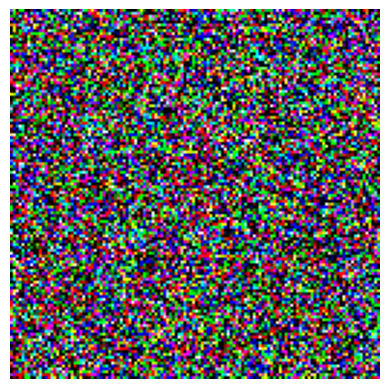

In [25]:
T=1000
import matplotlib.pyplot as plt
# Add noise to the image
sample=add_noise(image,T,device)

plt.imshow(np.transpose(sample.cpu().numpy().squeeze(0),(1,2,0)))
plt.axis('off')
plt.show()

In [30]:
# Generate a noisy image for demonstration (you should have a proper noisy image)
# noisy_image = forward_diffusion_sample(image, torch.tensor([T - 1], device=device).long(), device)[0]
# Denoise the image
T=100
denoised_image = denoise_image(model, sample, T, device)

# Convert the output tensor to an image and save or display it
denoised_image = denoised_image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
denoised_image = (denoised_image * 0.5 + 0.5) * 255  # De-normalize
denoised_image = denoised_image.astype(np.uint8)


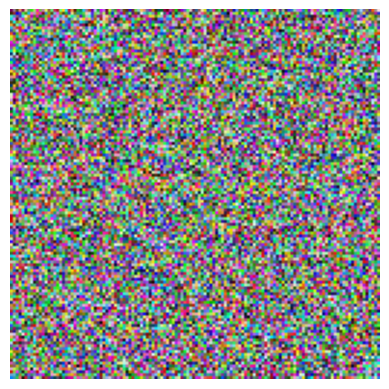

In [31]:
plt.imshow(denoised_image)
plt.axis('off')
plt.show()